Shapes - X_train: (183112, 48) X_test: (78477, 48)
Shapes - y_train: (183112,) y_test: (78477,)
Shapes after SMOTE - X_train_res: (455199, 48) y_train_res: (455199,)
Best parameters: {'max_depth': None, 'n_estimators': 200}
Epoch 1/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.6310 - loss: 0.8220 - val_accuracy: 0.1705 - val_loss: 1.5357
Epoch 2/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.7051 - loss: 0.6956 - val_accuracy: 0.2055 - val_loss: 1.5958
Epoch 3/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.7291 - loss: 0.6485 - val_accuracy: 0.2207 - val_loss: 1.5457
Epoch 4/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.7403 - loss: 0.6246 - val_accuracy: 0.3153 - val_loss: 1.3564
Epoch 5/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7472 - loss: 0.6092 - val_accuracy: 0.2272 - val_loss: 1.6257
Epoch 6/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.7531 - loss: 0.5956 - val_accuracy: 0.26


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.94      0.62      0.75     65029
         1.0       0.04      0.30      0.07      1974
         2.0       0.33      0.58      0.42     11474

    accuracy                           0.61     78477
   macro avg       0.44      0.50      0.41     78477
weighted avg       0.83      0.61      0.68     78477

ROC-AUC Score for Logistic Regression: 0.7404


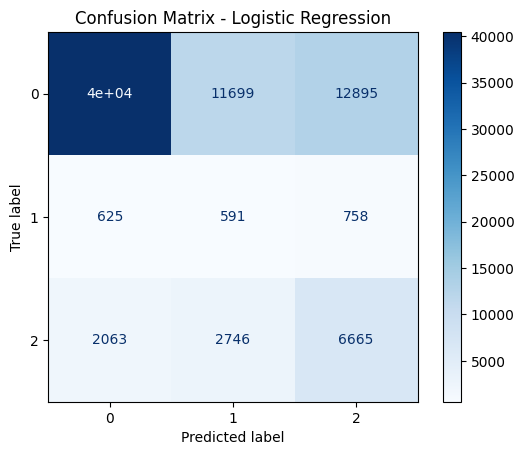


Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89     65029
         1.0       0.03      0.01      0.01      1974
         2.0       0.38      0.27      0.31     11474

    accuracy                           0.81     78477
   macro avg       0.42      0.40      0.40     78477
weighted avg       0.77      0.81      0.78     78477

ROC-AUC Score for Random Forest: 0.7055


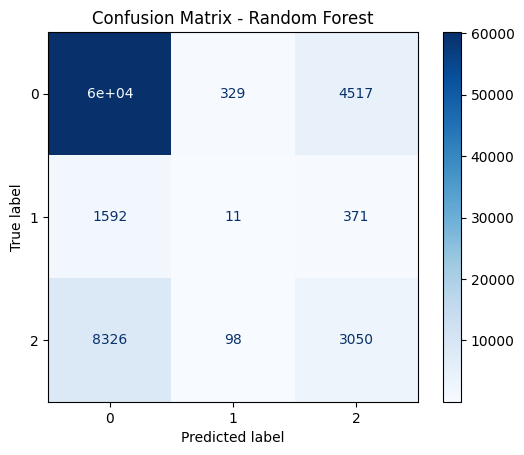


Classification Report for Tuned Random Forest:
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89     65029
         1.0       0.03      0.01      0.01      1974
         2.0       0.38      0.27      0.31     11474

    accuracy                           0.81     78477
   macro avg       0.42      0.40      0.40     78477
weighted avg       0.77      0.81      0.78     78477

ROC-AUC Score for Tuned Random Forest: 0.7055


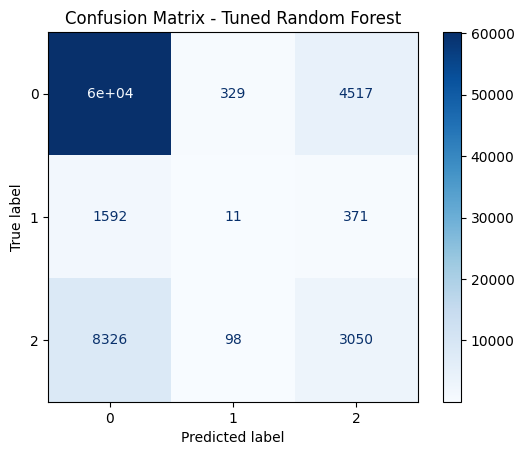

2453/2453 ━━━━━━━━━━━━━━━━━━━━ 2s 714us/step

Classification Report for Neural Network:
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87     65029
         1.0       0.03      0.12      0.05      1974
         2.0       0.43      0.30      0.35     11474

    accuracy                           0.76     78477
   macro avg       0.45      0.43      0.42     78477
weighted avg       0.79      0.76      0.77     78477

ROC-AUC Score for Neural Network: 0.7506


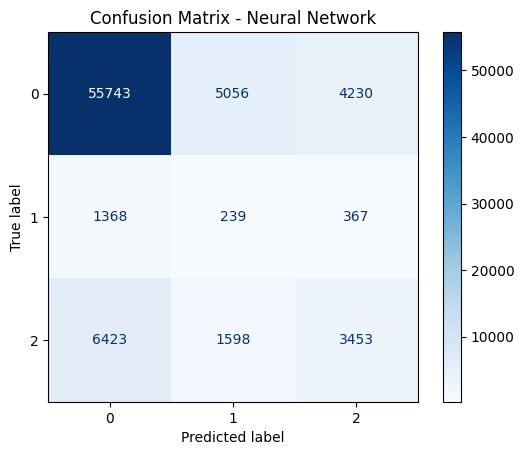

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV, train_test_split
from joblib import load, dump
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')  # Ignore deprecation warnings for now

# Define paths
processed_data_path = '../data/processed/'
models_path = '../models/'

# Create models directory if it doesn't exist
os.makedirs(models_path, exist_ok=True)

# Load preprocessed data
X_train = np.load(os.path.join(processed_data_path, 'X_train.npy'))
X_test = np.load(os.path.join(processed_data_path, 'X_test.npy'))
y_train = np.load(os.path.join(processed_data_path, 'y_train.npy'))
y_test = np.load(os.path.join(processed_data_path, 'y_test.npy'))

# Check shapes
print("Shapes - X_train:", X_train.shape, "X_test:", X_test.shape)
print("Shapes - y_train:", y_train.shape, "y_test:", y_test.shape)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_train_res = X_train_res.toarray() if hasattr(X_train_res, 'toarray') else X_train_res  # Ensure dense
y_train_res = y_train_res.astype(np.float32)  # Ensure picklable type
print("Shapes after SMOTE - X_train_res:", X_train_res.shape, "y_train_res:", y_train_res.shape)

# Hyperparameter Tuning for Random Forest with subset
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
X_train_sub, _, y_train_sub, _ = train_test_split(X_train_res, y_train_res, train_size=0.1, random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1_weighted', n_jobs=1)
grid_search.fit(X_train_sub, y_train_sub)
print("Best parameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train_res, y_train_res)  # Retrain on full data
dump(best_rf_model, os.path.join(models_path, 'random_forest_tuned.pkl'))

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_res, y_train_res)
dump(log_reg, os.path.join(models_path, 'logistic_regression_smote.pkl'))

# Train Tuned Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, class_weight='balanced')
rf_model.fit(X_train_res, y_train_res)
dump(rf_model, os.path.join(models_path, 'random_forest_smote_tuned.pkl'))

# Prepare data for Neural Network (one-hot encode y for multi-class)
y_train_cat = to_categorical(y_train_res, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Build and train Neural Network
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_res.shape[1],)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_res, y_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
nn_model.save(os.path.join(models_path, 'neural_net.h5'))

# Evaluate all models
models = {'Logistic Regression': log_reg, 'Random Forest': rf_model, 'Tuned Random Forest': best_rf_model}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score for {name}: {roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Evaluate Neural Network
y_pred_nn = nn_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)
print("\nClassification Report for Neural Network:")
print(classification_report(y_test, y_pred_nn_classes))
print(f"ROC-AUC Score for Neural Network: {roc_auc_score(y_test, y_pred_nn, multi_class='ovr', average='weighted'):.4f}")

cm_nn = confusion_matrix(y_test, y_pred_nn_classes)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)
disp_nn.plot(cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.show()

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Num GPUs Available: 0
No GPU detected. Training will use CPU.
Shapes - X_train: (183112, 48) X_test: (78477, 48)
Shapes - y_train: (183112,) y_test: (78477,)
Shapes after SMOTE - X_train_res: (183505, 48) y_train_res: (183505,)
Epoch 1/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8283 - loss: 0.4727 - val_accuracy: 0.8266 - val_loss: 0.4809
Epoch 2/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8307 - loss: 0.4550 - val_accuracy: 0.8267 - val_loss: 0.4791
Epoch 3/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8318 - loss: 0.4517 - val_accuracy: 0.8261 - val_loss: 0.4776
Epoch 4/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8320 - loss: 0.4493 - val_accuracy: 0.8267 - val_loss: 0.4770
Epoch 5/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8325 - loss: 0.4484 - val_accuracy: 0.8277 - val_loss: 0.4790
Epoch 6/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8326 - loss: 0.4465 - val_accuracy: 0.8256 - val_loss

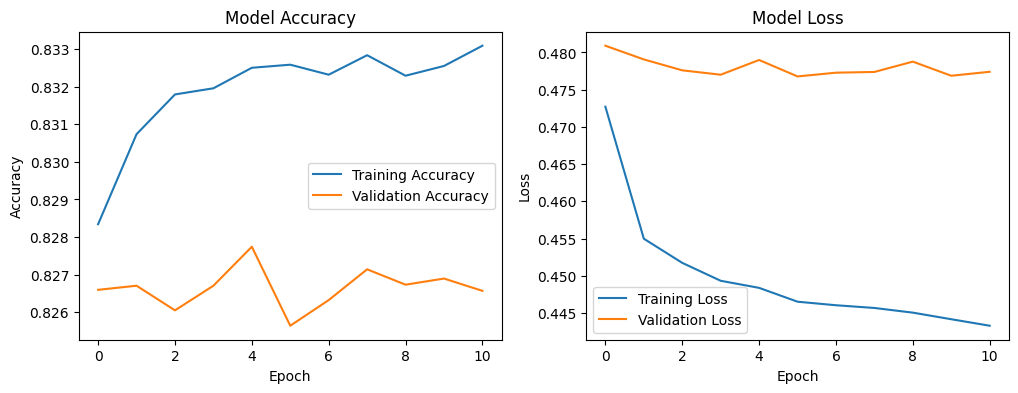


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.94      0.63      0.76     65029
         1.0       0.04      0.29      0.07      1974
         2.0       0.33      0.60      0.42     11474

    accuracy                           0.62     78477
   macro avg       0.44      0.51      0.42     78477
weighted avg       0.83      0.62      0.69     78477

ROC-AUC Score for Logistic Regression: 0.7458


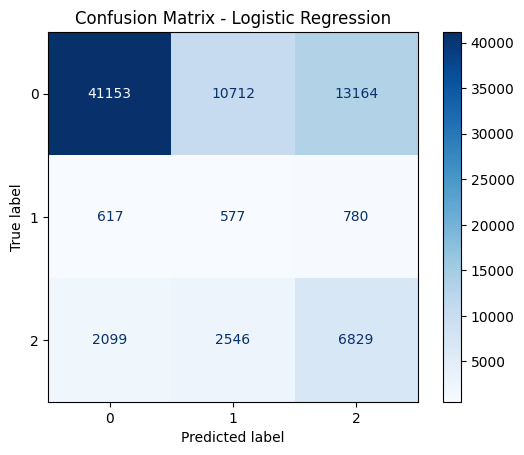


Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89     65029
         1.0       0.02      0.01      0.01      1974
         2.0       0.37      0.15      0.21     11474

    accuracy                           0.81     78477
   macro avg       0.41      0.37      0.37     78477
weighted avg       0.75      0.81      0.77     78477

ROC-AUC Score for Random Forest: 0.7046


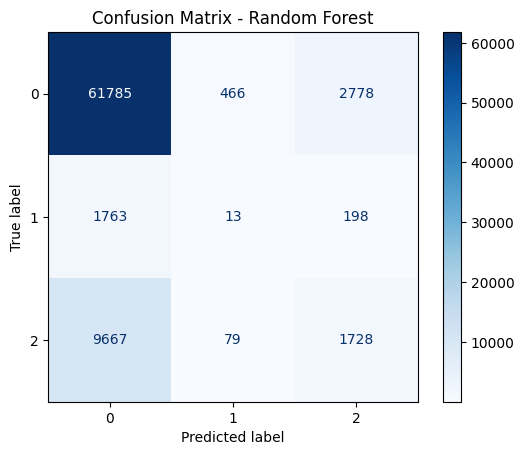

2453/2453 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Classification Report for Neural Network:
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91     65029
         1.0       0.00      0.00      0.00      1974
         2.0       0.62      0.05      0.09     11474

    accuracy                           0.83     78477
   macro avg       0.49      0.35      0.33     78477
weighted avg       0.78      0.83      0.76     78477

ROC-AUC Score for Neural Network: 0.7935


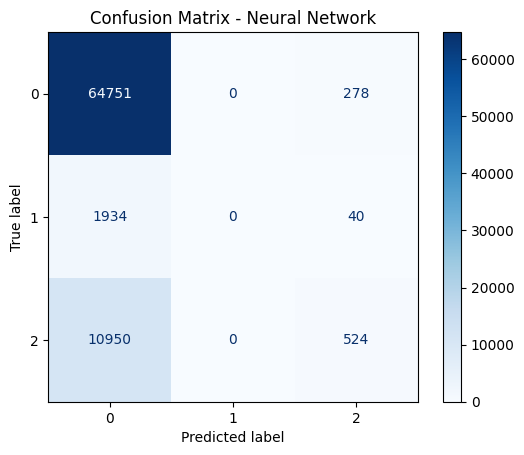

In [6]:

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

# Verify GPU availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("GPU:", tf.config.list_physical_devices('GPU')[0].name)
else:
    print("No GPU detected. Training will use CPU.")

# Define paths
processed_data_path = '../data/processed/'
models_path = '../models/'

# Create models directory if it doesn't exist
os.makedirs(models_path, exist_ok=True)

# Load preprocessed data
X_train = np.load(os.path.join(processed_data_path, 'X_train.npy'))
X_test = np.load(os.path.join(processed_data_path, 'X_test.npy'))
y_train = np.load(os.path.join(processed_data_path, 'y_train.npy'))
y_test = np.load(os.path.join(processed_data_path, 'y_test.npy'))

# Check shapes
print("Shapes - X_train:", X_train.shape, "X_test:", X_test.shape)
print("Shapes - y_train:", y_train.shape, "y_test:", y_test.shape)

# Apply SMOTE with adjusted sampling strategy
smote = SMOTE(sampling_strategy={1: 5000, 2: 26772}, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_train_res = X_train_res.toarray() if hasattr(X_train_res, 'toarray') else X_train_res
y_train_res = y_train_res.astype(np.float32)
print("Shapes after SMOTE - X_train_res:", X_train_res.shape, "y_train_res:", y_train_res.shape)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_res, y_train_res)
dump(log_reg, os.path.join(models_path, 'logistic_regression_smote.pkl'))

# Train Random Forest with tuned parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, class_weight='balanced')
rf_model.fit(X_train_res, y_train_res)
dump(rf_model, os.path.join(models_path, 'random_forest_smote_tuned.pkl'))

# Prepare data for Neural Network
y_train_cat = to_categorical(y_train_res, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Build and train Neural Network with CPU/GPU support
with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
    nn_model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = nn_model.fit(X_train_res, y_train_cat, epochs=30, batch_size=128, validation_split=0.2,
                          verbose=1, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])
    nn_model.save(os.path.join(models_path, 'neural_net_tuned.h5'))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate all models
models = {'Logistic Regression': log_reg, 'Random Forest': rf_model}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score for {name}: {roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'):.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Evaluate Neural Network
y_pred_nn = nn_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)
print("\nClassification Report for Neural Network:")
print(classification_report(y_test, y_pred_nn_classes))
print(f"ROC-AUC Score for Neural Network: {roc_auc_score(y_test, y_pred_nn, multi_class='ovr', average='weighted'):.4f}")

cm_nn = confusion_matrix(y_test, y_pred_nn_classes)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)
disp_nn.plot(cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.show()